# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




In [1]:
# импорты:
import torch
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [2]:
!wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/transfer_learning_hg/lenta_sample.csv -q

data = pd.read_csv("lenta_sample.csv")

In [3]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [4]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [6]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, tokenizer, num_classes, method="cls"):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)
        self.method = method
        if self.method == "cls":
            print("The classifier uses the first hidden state (cls) outputted from BERT's last layer.")
        elif self.method == "avg_pool":
            print("The classifier uses the average across hidden states of all tokens outputted from BERT's last layer.")
        else:
            raise ValueError("Expected 'cls' or 'avg_pool' as method")

    def forward(self, texts):
        mask = (texts != self.tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        if self.method == "cls":
            # берем самое первое состояние (cls)
            hidden_for_classifier = hidden[:, 0]
        elif self.method == "avg_pool":
            # берем среднее по всем состояниям
            hidden_for_classifier = hidden.mean(dim=1)

        outputs = self.act(self.fc(self.drop(hidden_for_classifier)))

        return outputs

In [11]:
def train(model, iterator, optimizer, criterion, print_every=1000):
    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))

        loss.backward()
        optimizer.step()
        preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f"Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}")

    return np.mean(epoch_f1)

In [12]:
def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            y_true = ys.tolist()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)

In [13]:
def predict(model, iterator):
    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [14]:
def training_init(model_id, max_len=512, method="cls", freeze_bert=False):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model_bert = AutoModel.from_pretrained(model_id)

    if freeze_bert:
        for param in model_bert.parameters():
            param.requires_grad = False

    training_set = Dataset(tokenizer, max_len, train_texts, train_targets)
    training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
    valid_set = Dataset(tokenizer, max_len, valid_texts, valid_targets)
    valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

    model = CLF(model_bert, tokenizer, len(label2id), method)
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.NLLLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    return model, training_generator, valid_generator, optimizer, criterion

In [ ]:
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "answerdotai/ModernBERT-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0


W0629 13:14:07.197000 362 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Eval -  0.06451612903225806
1
Eval -  0.03225806451612903
2
Eval -  0.03225806451612903
3
Eval -  0.03225806451612903
4
Eval -  0.0
5
Eval -  0.06451612903225806
6
Eval -  0.06451612903225806
7
Eval -  0.0967741935483871
8
Eval -  0.1935483870967742
9
Eval -  0.25806451612903225
10
Eval -  0.25806451612903225
11
Eval -  0.1935483870967742
12
Eval -  0.16129032258064516
13
Eval -  0.1935483870967742
14
Eval -  0.0967741935483871
15
Eval -  0.12903225806451613
16
Eval -  0.12903225806451613
17
Eval -  0.1935483870967742
18
Eval -  0.0967741935483871
19
Eval -  0.12903225806451613
20
Eval -  0.0967741935483871
21
Eval -  0.12903225806451613
22
Eval -  0.12903225806451613
23
Eval -  0.0967741935483871
24
Eval -  0.0967741935483871
25
Eval -  0.16129032258064516
26
Eval -  0.16129032258064516
27
Eval -  0.16129032258064516
28
Eval -  0.16129032258064516
29
Eval -  0.16129032258064516


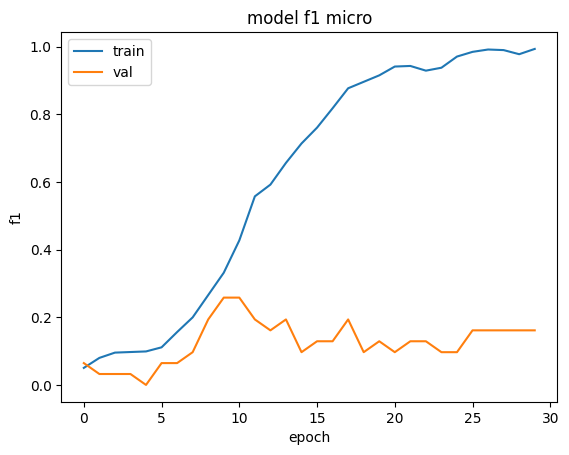

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.67      0.67      0.67         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.50      0.25      0.33         4
           8       0.50      0.25      0.33         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.25      0.33      0.29         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2

    accuracy              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

f-мера превысила 0.32, но только у 4 из 17 классов метрики ненулевые. Модель сильно переобучилась под трейн, нужны улучшения

## Модель **2**

In [ ]:
# RuModernBERT-base (дообучение целиком)
model, training_generator, valid_generator, optimizer, criterion = training_init('deepvk/RuModernBERT-base')

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

The classifier uses the first hidden state (cls) outputted from BERT's last layer.


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

0
Eval -  0.03225806451612903
1
Eval -  0.12903225806451613
2
Eval -  0.03225806451612903
3
Eval -  0.03225806451612903
4
Eval -  0.0967741935483871
5
Eval -  0.1935483870967742
6
Eval -  0.3225806451612903
7
Eval -  0.3225806451612903
8
Eval -  0.41935483870967744
9
Eval -  0.4838709677419355
10
Eval -  0.4838709677419355
11
Eval -  0.4838709677419355
12
Eval -  0.5483870967741935
13
Eval -  0.45161290322580644
14
Eval -  0.45161290322580644
15
Eval -  0.41935483870967744
16
Eval -  0.41935483870967744
17
Eval -  0.41935483870967744
18
Eval -  0.41935483870967744
19
Eval -  0.41935483870967744
20
Eval -  0.41935483870967744
21
Eval -  0.41935483870967744
22
Eval -  0.41935483870967744
23
Eval -  0.41935483870967744
24
Eval -  0.41935483870967744
25
Eval -  0.41935483870967744
26
Eval -  0.41935483870967744
27
Eval -  0.41935483870967744
28
Eval -  0.41935483870967744
29
Eval -  0.41935483870967744


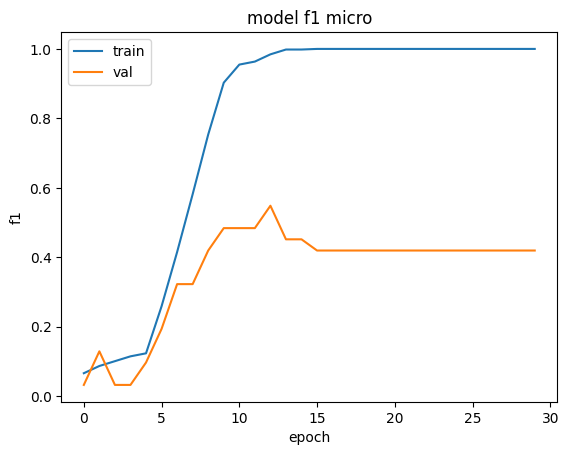

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0
           2       0.67      0.67      0.67         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         5
           7       0.40      0.50      0.44         4
           8       0.33      0.50      0.40         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       1.00      0.33      0.50         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2

    accuracy              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Accuracy превысила 0.42 - в 1.5 раза больше, чем у ModernBert , потому что обучлася уже на русском. Ненулевые метрики теперь у 6 классов из 17. Модель ожидаемо переобучилась под трейн раньше, чем ModernBert

In [15]:
# ModernBERT-base (дообучение только fully-connected слоя для классификации)
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "answerdotai/ModernBERT-base", freeze_bert=True)
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

The classifier uses the first hidden state (cls) outputted from BERT's last layer.
0


W0629 15:21:29.524000 471 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Eval -  0.12903225806451613
1
Eval -  0.16129032258064516
2
Eval -  0.12903225806451613
3
Eval -  0.22580645161290322
4
Eval -  0.25806451612903225
5
Eval -  0.22580645161290322
6
Eval -  0.25806451612903225
7
Eval -  0.1935483870967742
8
Eval -  0.25806451612903225
9
Eval -  0.22580645161290322
10
Eval -  0.22580645161290322
11
Eval -  0.1935483870967742
12
Eval -  0.1935483870967742
13
Eval -  0.22580645161290322
14
Eval -  0.25806451612903225
15
Eval -  0.2903225806451613
16
Eval -  0.2903225806451613
17
Eval -  0.2903225806451613
18
Eval -  0.2903225806451613
19
Eval -  0.3225806451612903
20
Eval -  0.3225806451612903
21
Eval -  0.2903225806451613
22
Eval -  0.2903225806451613
23
Eval -  0.3225806451612903
24
Eval -  0.2903225806451613
25
Eval -  0.2903225806451613
26
Eval -  0.2903225806451613
27
Eval -  0.2903225806451613
28
Eval -  0.2903225806451613
29
Eval -  0.2903225806451613


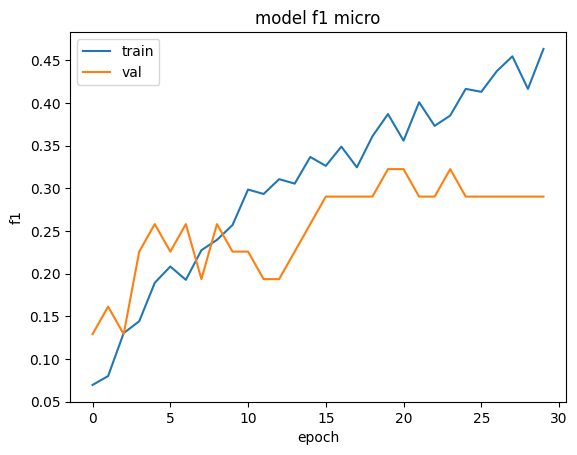

In [16]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [17]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.11      0.33      0.17         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         2
           7       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.67      1.00      0.80         4
          13       0.33      1.00      0.50         1
          14       0.67      1.00      0.80         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1

    accuracy                           0.29        31
   macro avg       0.18      0.28      0.21        31
weighted avg       0.20      0.29      0.23        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Качество чуточук ниже, чем у моделей без заморозки берта. Ненулевые поклассовые метрики только у 4 классов. Переобучение наблюдается, но за 30 эпох модель смогла подогнаться только под accuracy = ~0.30 на трейне а график accuracy не вышел на плато.

In [18]:
# RuModernBERT-base (дообучение только fully-connected слоя для классификации)
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base", freeze_bert=True
)
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

The classifier uses the first hidden state (cls) outputted from BERT's last layer.
0
Eval -  0.06451612903225806
1
Eval -  0.06451612903225806
2
Eval -  0.06451612903225806
3
Eval -  0.0967741935483871
4
Eval -  0.12903225806451613
5
Eval -  0.06451612903225806
6
Eval -  0.0967741935483871
7
Eval -  0.0967741935483871
8
Eval -  0.16129032258064516
9
Eval -  0.0967741935483871
10
Eval -  0.0967741935483871
11
Eval -  0.06451612903225806
12
Eval -  0.06451612903225806
13
Eval -  0.06451612903225806
14
Eval -  0.12903225806451613
15
Eval -  0.0967741935483871
16
Eval -  0.16129032258064516
17
Eval -  0.0967741935483871
18
Eval -  0.16129032258064516
19
Eval -  0.06451612903225806
20
Eval -  0.16129032258064516
21
Eval -  0.0967741935483871
22
Eval -  0.0967741935483871
23
Eval -  0.0967741935483871
24
Eval -  0.06451612903225806
25
Eval -  0.12903225806451613
26
Eval -  0.06451612903225806
27
Eval -  0.12903225806451613
28
Eval -  0.0967741935483871
29
Eval -  0.16129032258064516


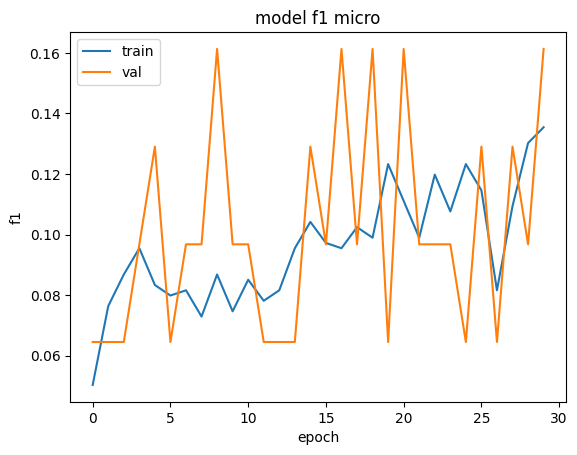

In [19]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [20]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.08      0.33      0.12         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.50      0.50      0.50         4
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.15      1.00      0.27         2
          16       0.00      0.00      0.00         1

    accuracy                           0.16        31
   macro avg       0.06      0.14      0.07        31
weighted avg       0.08      0.16      0.09        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy даже на трейне едва перешагнула отметку 0.1. Модели не хватает эпох.

In [21]:
# RuModernBERT-base (дообучение целиком, усредненный hidden state)
model, training_generator, valid_generator, optimizer, criterion = training_init(
    "deepvk/RuModernBERT-base", method="avg_pool")
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print("Eval - ", evl)
    f1s_eval.append(evl)

The classifier uses the average across hidden states of all tokens outputted from BERT's last layer.
0
Eval -  0.5483870967741935
1
Eval -  0.6774193548387096
2
Eval -  0.6129032258064516
3
Eval -  0.7419354838709677
4
Eval -  0.6774193548387096
5
Eval -  0.6774193548387096
6
Eval -  0.7096774193548387
7
Eval -  0.7096774193548387
8
Eval -  0.7096774193548387
9
Eval -  0.7096774193548387
10
Eval -  0.7096774193548387
11
Eval -  0.7096774193548387
12
Eval -  0.7419354838709677
13
Eval -  0.7419354838709677
14
Eval -  0.7419354838709677
15
Eval -  0.7419354838709677
16
Eval -  0.7419354838709677
17
Eval -  0.7419354838709677
18
Eval -  0.7419354838709677
19
Eval -  0.7419354838709677
20
Eval -  0.7419354838709677
21
Eval -  0.7419354838709677
22
Eval -  0.7419354838709677
23
Eval -  0.7419354838709677
24
Eval -  0.7419354838709677
25
Eval -  0.7419354838709677
26
Eval -  0.7419354838709677
27
Eval -  0.7419354838709677
28
Eval -  0.7419354838709677
29
Eval -  0.7419354838709677


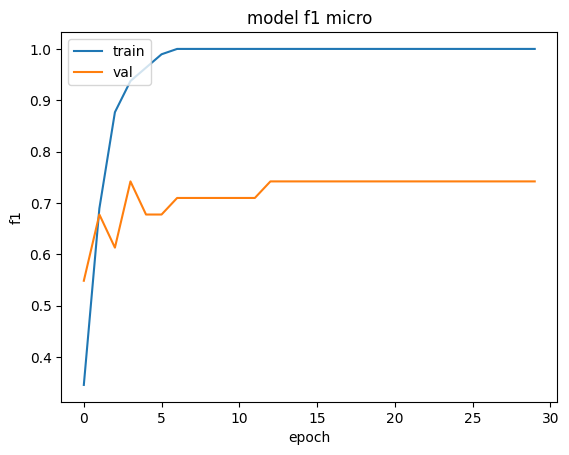

In [22]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()


In [23]:
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           2       1.00      0.50      0.67         2
           3       0.50      0.33      0.40         3
           4       1.00      0.57      0.73         7
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         3
          10       0.67      1.00      0.80         2
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         4
          13       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       0.50      1.00      0.67         1

    accuracy                           0.74        31
   macro avg       0.64      0.71      0.64        31
weighted avg       0.81      0.74      0.74        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

А вот тут на удивление модель очень хорошо справилась и качество выше гораздо чем у предыдущих моделей. аккураси около 67 это очнеь хороший показатель, хотя и очевидно, что модель переобучилась жестко